In [19]:
import argparse
import io
import math
import os
import pathlib
import sys
from typing import List, Tuple

import torch
import requests
import numpy as np
from PIL import Image, ImageFilter  
import matplotlib.pyplot as plt

from transformers import AutoImageProcessor, AutoConfig, ViTForImageClassification, ViTImageProcessor, ViTModel

import torch, torch.nn as nn, torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Subset
import numpy as np
import math
from PIL import ImageDraw

### Using a Pre-trained ViT for Image Classification

Loading Model

In [5]:
MODEL_NAME = "google/vit-base-patch16-224"

config = AutoConfig.from_pretrained(MODEL_NAME)
config.output_attentions = True
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
model = ViTForImageClassification.from_pretrained(MODEL_NAME, config=config)
model.eval()

if torch.cuda.is_available():
    model.to("cuda")
    device = "cuda"

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 30393.51it/s]


Loading Images

In [6]:
DEFAULT_IMAGE_URLS = [
    "https://images.unsplash.com/photo-1518791841217-8f162f1e1131",  # cat
    "https://images.unsplash.com/photo-1518020382113-a7e8fc38eac9",  # dog
]

def is_url(s: str) -> bool:
    return s.startswith("http://") or s.startswith("https://")

def load_image_from_url(url: str, timeout: int = 10) -> Image.Image:
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    return Image.open(io.BytesIO(r.content)).convert("RGB")

def load_image_from_path(p: str) -> Image.Image:
    return Image.open(p).convert("RGB")

def load_images(sources: List[str]) -> List[Tuple[str, Image.Image]]:
    images = []
    for src in sources:
        try:
            if is_url(src):
                img = load_image_from_url(src)
                name = src.split("/")[-1] or "image"
            else:
                img = load_image_from_path(src)
                name = pathlib.Path(src).stem
            images.append((name, img))
        except Exception as e:
            print(f"[WARN] Failed to load '{src}': {e}", file=sys.stderr)
    return images


In [7]:
sources = DEFAULT_IMAGE_URLS
items = load_images(sources)
pil_images = [img for (_, img) in items]

In [8]:
inputs = processor(images=pil_images, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

Inference

In [9]:
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)
    logits = outputs.logits
    attentions = outputs.attentions

probs = logits.softmax(dim=-1)
top1_ids = probs.argmax(dim=-1).tolist()

[RESULT] photo-1518791841217-8f162f1e1131: Top-1 = tabby, tabby cat (p=0.480)
[RESULT] photo-1518020382113-a7e8fc38eac9: Top-1 = pug, pug-dog (p=0.610)


/tmp/ipykernel_1228817/4017790662.py:65: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  heat = Image.fromarray(arr, mode="L")
/tmp/ipykernel_1228817/4017790662.py:89: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  heat_rgba = Image.fromarray(rgba, mode="RGBA")


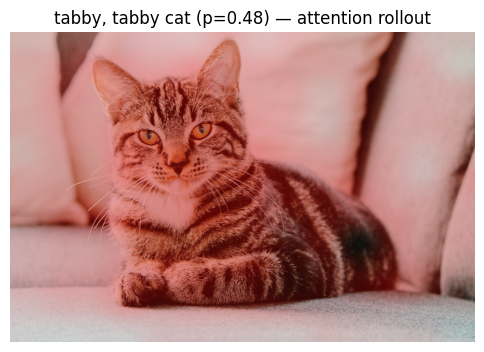

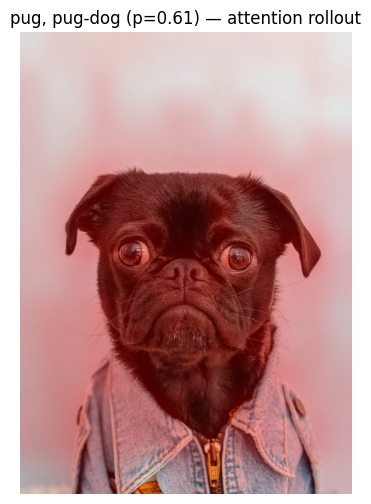

In [10]:
@torch.no_grad()
def attention_rollout(attentions: List[torch.Tensor]) -> torch.Tensor:
    """
    Implements the "rolling attention" described in the article:
      - Fuse heads with mean
      - Add identity (A + I)
      - Row-normalize
      - Multiply across layers

    attentions: list of length L_layers, each tensor (B, H, T, T)
    returns: rollout (B, T, T)
    """
    # Start with identity
    T = attentions[0].size(-1)
    device = attentions[0].device
    rollout = torch.eye(T, device=device).unsqueeze(0)  # (1, T, T)

    for A in attentions:
        # mean over heads -> (B, T, T)
        A_fused = A.mean(dim=1)
        # add identity
        I = torch.eye(T, device=A_fused.device).unsqueeze(0)  # (1, T, T)
        A_aug = A_fused + I
        # row-normalize
        A_norm = A_aug / A_aug.sum(dim=-1, keepdim=True)
        # multiply (broadcast batch): (B,T,T) = (B,T,T) @ (B,T,T) via per-sample matmul
        rollout = rollout @ A_norm

    return rollout  # (B, T, T)


def cls_to_patches_from_rollout(rollout: torch.Tensor, follow_medium_indexing: bool = True) -> torch.Tensor:
    """
    Extract a CLS↔patch vector from rollout.

    The Medium post indexes like: rollout[0, 1:, 0]
    We'll support that *and* the more common 'row=CLS -> cols=patches' (rollout[0, 0, 1:]).
    By default, we follow the Medium post to honor the user's request.
    """
    # rollout: (B, T, T), where T = 1 + num_patches
    if follow_medium_indexing:
        vec = rollout[:, 1:, 0]  # (B, num_patches)
        # The article inverted then normalized; we keep that behavior:
        vec = 1.0 - vec
    else:
        vec = rollout[:, 0, 1:]  # (B, num_patches)

    # Normalize each sample to [0,1] for visualization
    vec = (vec - vec.amin(dim=1, keepdim=True)) / (vec.amax(dim=1, keepdim=True) - vec.amin(dim=1, keepdim=True) + 1e-6)
    return vec  # (B, num_patches) in [0,1]


# ----------------------- Viz helpers -----------------------

def upsample_attention_to_image(attn_vec: torch.Tensor, target_size: Tuple[int, int]) -> Image.Image:
    """
    attn_vec: (num_patches,) torch tensor in [0,1]
    target_size: (W, H)
    returns a PIL Image (mode 'L') resized to target_size
    """
    num_patches = attn_vec.numel()
    grid = int(math.sqrt(num_patches))
    assert grid * grid == num_patches, f"num_patches={num_patches} is not a square"
    arr = (attn_vec.detach().cpu().numpy().reshape(grid, grid) * 255).astype(np.uint8)
    heat = Image.fromarray(arr, mode="L")
    heat = heat.resize(target_size, resample=Image.BICUBIC)
    # Optional smoothing as in the article
    heat = heat.filter(ImageFilter.GaussianBlur(radius=2))
    return heat  # grayscale (L)

def overlay_heatmap_rgba(image: Image.Image, heat_gray: Image.Image, alpha: int = 100,
                         save_path: str = None, title: str = None):
    """
    Red RGBA overlay: R=255, G=B=0. Alpha is scaled by heat intensity.
    `alpha` is the maximum opacity (0–255).
    """
    # Heat in [0,255] -> per-pixel alpha in [0, alpha]
    heat_arr = np.array(heat_gray.convert("L")).astype(np.float32)  # (H, W)
    a = (heat_arr / 255.0) * float(alpha)
    a = a.clip(0, 255).astype(np.uint8)

    H, W = heat_arr.shape
    rgba = np.zeros((H, W, 4), dtype=np.uint8)
    rgba[..., 0] = 255          # Red channel
    rgba[..., 1] = 0            # Green
    rgba[..., 2] = 0            # Blue
    rgba[..., 3] = a            # Alpha from heat

    heat_rgba = Image.fromarray(rgba, mode="RGBA")

    # Compose
    base = image.convert("RGBA")
    composed = Image.alpha_composite(base, heat_rgba)

    # Save/Show
    plt.figure(figsize=(6, 6))
    plt.imshow(composed)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()
    plt.close()

# ----------------------- Main -----------------------
# Top-1 predictions
probs = logits.softmax(dim=-1)
top1_ids = probs.argmax(dim=-1).tolist()
id2label = {int(k): v for k, v in model.config.id2label.items()}

for i, ((name, img), cls_id) in enumerate(zip(items, top1_ids)):
    label = id2label.get(cls_id, f"class_{cls_id}")
    conf = probs[i, cls_id].item()
    print(f"[RESULT] {name}: Top-1 = {label} (p={conf:.3f})")

# Attention rollout (per article)
rollout = attention_rollout(attentions)         # (B, T, T)

# CLS↔patch vector (follow the article’s indexing by default)
cls_vecs = cls_to_patches_from_rollout(rollout, follow_medium_indexing=True)  # (B, num_patches)

# Build overlays
for i, (name, img) in enumerate(items):
    heat_L = upsample_attention_to_image(cls_vecs[i], (img.size[0], img.size[1]))  # grayscale 'L'
    title = f"{id2label.get(top1_ids[i], str(top1_ids[i]))} (p={probs[i, top1_ids[i]].item():.2f}) — attention rollout"
    out_path = f"{name}__attn.png"
    overlay_heatmap_rgba(img, heat_L, alpha=100, save_path=out_path, title=title)

### Visualizing Patch Attention - Old Method

In [11]:
def normalize_to_01(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    mn, mx = x.min(dim=-1, keepdim=True).values, x.max(dim=-1, keepdim=True).values
    return (x - mn) / (mx - mn + eps)

def get_cls_to_patches_attention_per_head(
    attentions: List[torch.Tensor],
    follow_medium_indexing: bool = True,   # True → tokens(1:)→CLS(0); False → CLS(0)→tokens(1:)
    normalize: bool = True
) -> torch.Tensor:
    """
    Extract per-head CLS/patch attentions from the last layer.
    attentions: list of tensors (B, H, L, L)
    returns: (B, H, num_patches)  in [0,1] if normalize=True
    """
    last = attentions[-1]                       # (B, H, L, L)
    B, H, L, _ = last.shape

    if follow_medium_indexing:
        # Medium article style: attention from tokens(1:) → CLS(0)
        # shape (B, H, L-1)
        cls_rel = last[:, :, 1:, 0]
    else:
        # Conventional: CLS(0) → tokens(1:)
        # shape (B, H, L-1)
        cls_rel = last[:, :, 0, 1:]

    if normalize:
        cls_rel = normalize_to_01(cls_rel)      # normalize per (B,H) along last dim

    return cls_rel                               # (B, H, num_patches)


In [12]:
def ensure_dir(p: str):
    pathlib.Path(p).parent.mkdir(parents=True, exist_ok=True)
    
def attention_map_to_heatmap(
    attn_vec: torch.Tensor,
    ref_img_size: Tuple[int, int]
) -> np.ndarray:
    """
    Convert a flat attention vector (num_patches) to an upsampled heatmap (H,W).
    Assumes a square patch grid (e.g., 14x14 for 224 with 16x16 patches).
    """
    num_patches = attn_vec.numel()
    grid = int(math.sqrt(num_patches))
    assert grid * grid == num_patches, f"num_patches={num_patches} is not a perfect square."

    # Reshape to grid
    attn_grid = attn_vec.reshape(grid, grid).detach().cpu().numpy()

    # Upsample to image size using PIL
    attn_img = Image.fromarray((attn_grid * 255).astype(np.uint8))
    attn_img = attn_img.resize(ref_img_size, resample=Image.BICUBIC)
    return np.array(attn_img).astype(np.float32) / 255.0  # back to [0,1]


def overlay_heatmap_on_image(
    image: Image.Image,
    heatmap: np.ndarray,
    alpha: float = 0.45,
    cmap: str = "jet",
    save_path: str = None,
    title: str = None
):
    """
    Show and optionally save an overlay of the heatmap on the image.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.imshow(heatmap, cmap=cmap, alpha=alpha, interpolation="bilinear")
    if title:
        plt.title(title)
    plt.axis("off")

    if save_path:
        ensure_dir(save_path)
        plt.savefig(save_path, bbox_inches="tight", dpi=200)
        print(f"[INFO] Saved attention overlay → {save_path}")
    plt.close()


In [13]:
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize_heads_grid_for_image(
    image: Image.Image,
    head_vecs,                    # (H, num_patches) torch.Tensor
    alpha: float = 0.45,
    cmap: str = "Reds",           # "Reds" gives a red overlay
    suptitle: str | None = None,
    save_path: str | None = None,
    max_cols: int | None = None,  # set to force columns (e.g., 4)
):
    """
    Visualize per-head CLS/patch attention for ONE image as a grid.
    - image: PIL.Image
    - head_vecs: (H, num_patches) torch tensor (already normalized if you prefer)
    - alpha: overlay opacity
    - cmap: matplotlib colormap; 'Reds' gives a red overlay feel
    - max_cols: optionally cap the number of columns
    """
    H = head_vecs.shape[0]

    # Choose grid layout
    if max_cols is not None:
        cols = min(max_cols, H)
        rows = math.ceil(H / cols)
    else:
        cols = int(math.ceil(math.sqrt(H)))
        rows = int(math.ceil(H / cols))

    fig_w = 3 * cols
    fig_h = 3 * rows
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    axes = axes.reshape(rows, cols)

    W, H_px = image.size

    for idx in range(rows * cols):
        r = idx // cols
        c = idx % cols
        ax = axes[r, c]
        ax.axis("off")

        if idx >= head_vecs.shape[0]:
            ax.imshow(image)
            continue

        # Build heatmap for this head
        heatmap = attention_map_to_heatmap(head_vecs[idx], (W, H_px))

        # Overlay (image first, then heatmap)
        ax.imshow(image)
        ax.imshow(heatmap, cmap=cmap, alpha=alpha, interpolation="bilinear")
        ax.set_title(f"Head {idx}", fontsize=10)

    if suptitle:
        fig.suptitle(suptitle, fontsize=12)

    fig.tight_layout()
    plt.show()


In [14]:
# (B, H, num_patches)
cls_patch_attn_ph = get_cls_to_patches_attention_per_head(
    attentions,
    follow_medium_indexing=True,   # or False for CLS→patches
    normalize=True
)

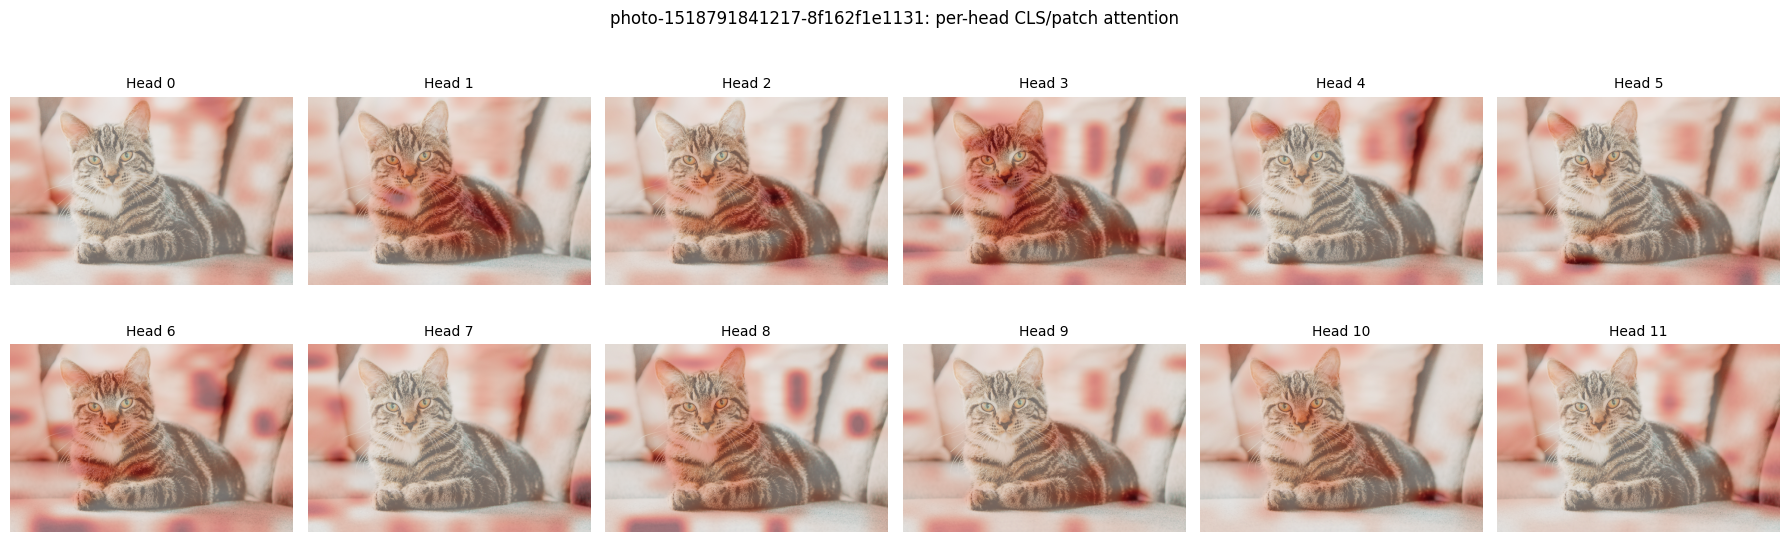

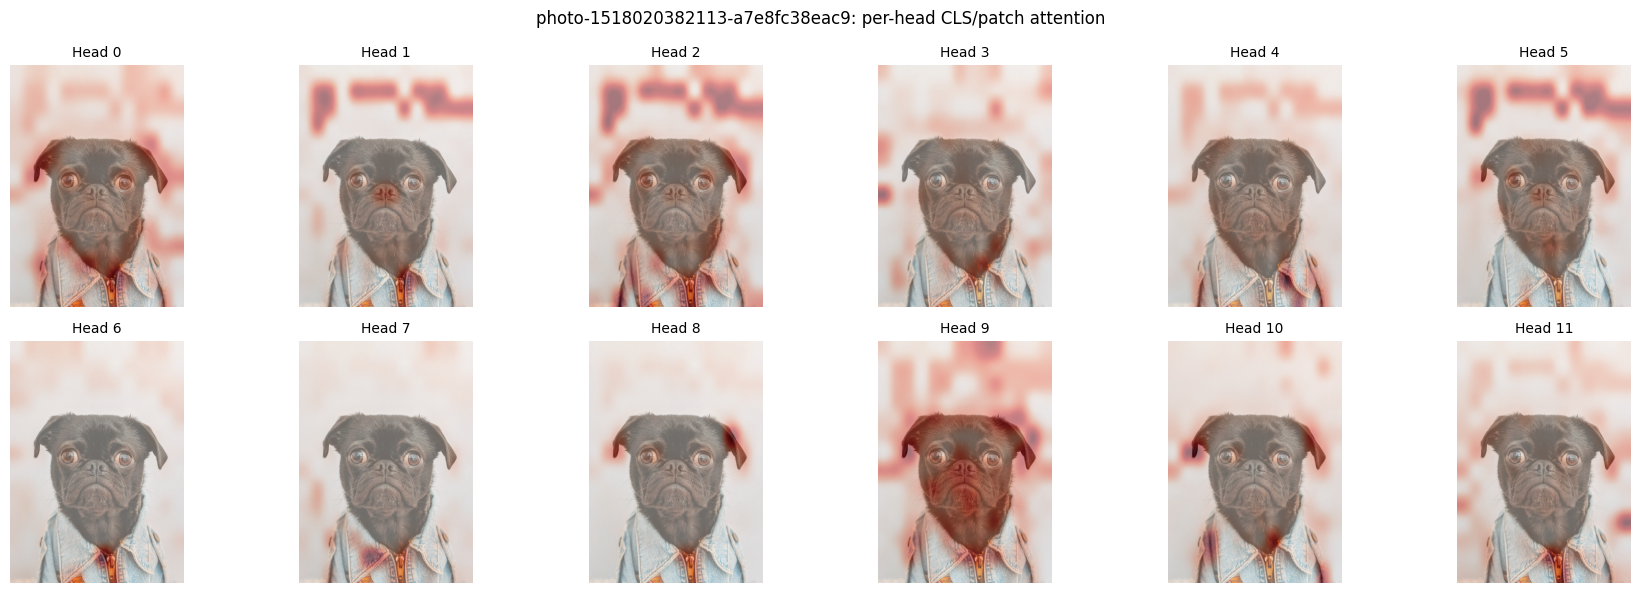

In [13]:


B, H, _ = cls_patch_attn_ph.shape
for i, (name, pil_img) in enumerate(items):
    visualize_heads_grid_for_image(
        image=pil_img,
        head_vecs=cls_patch_attn_ph[i],           # (H, num_patches) for this image
        alpha=0.45,
        cmap="Reds",                               # red overlay
        suptitle=f"{name}: per-head CLS/patch attention",
        max_cols=6                                 # optional; nice for many heads
    )


## Masking

Robustness to missing patches (consistency vs unmasked prediction):
random   frac=0.00  consistency=1.000  Δconf=-0.126
random   frac=0.10  consistency=1.000  Δconf=-0.141
random   frac=0.25  consistency=1.000  Δconf=-0.260
random   frac=0.50  consistency=1.000  Δconf=-0.136
random   frac=0.75  consistency=0.000  Δconf=0.326
center   frac=0.00  consistency=1.000  Δconf=-0.126
center   frac=0.10  consistency=1.000  Δconf=-0.130
center   frac=0.25  consistency=0.500  Δconf=0.164
center   frac=0.50  consistency=0.000  Δconf=0.279
center   frac=0.75  consistency=0.000  Δconf=-0.032


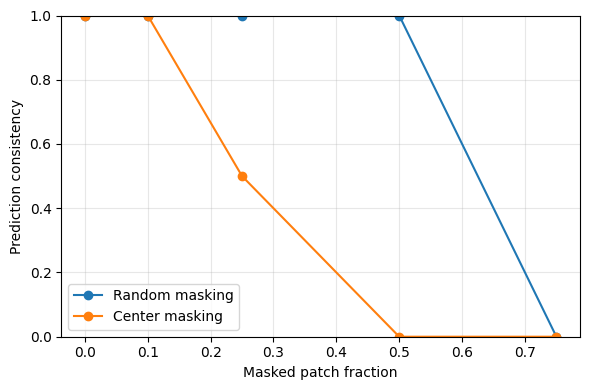

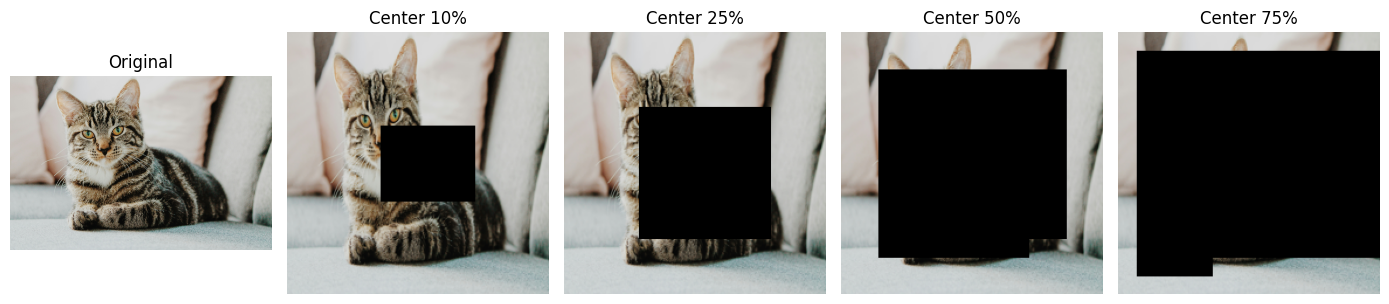

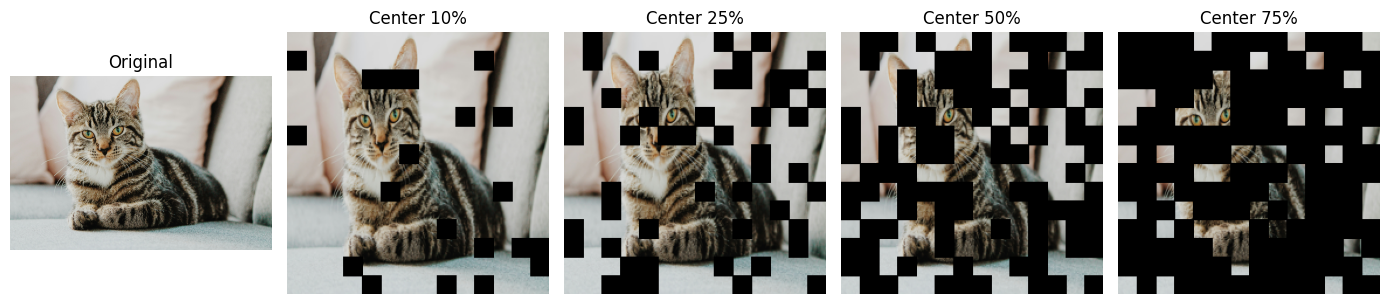

In [ ]:
def get_device_from_model(model):
    try:
        return next(model.parameters()).device.type
    except StopIteration:
        return "cpu"

def get_img_size_from_processor(processor):
    # HF processors sometimes store size as dict {"height":224,"width":224} or as int 224
    if isinstance(processor.size, dict):
        return int(processor.size.get("height", list(processor.size.values())[0]))
    return int(processor.size)

def predict_top1(model, processor, pil_images):
    device = get_device_from_model(model)
    inputs = processor(images=pil_images, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = logits.softmax(dim=-1)
        top1 = probs.argmax(dim=-1)
        top1_prob = probs.max(dim=-1).values
    return top1.cpu().numpy(), top1_prob.cpu().numpy()

def mask_patches(pil_img, img_size, patch_size, frac, mode="random"):
    """
    Returns a *new* PIL image where a fraction of patches are masked (filled black).
    mode: "random" | "center"
    """
    assert 0.0 <= frac <= 1.0
    img = pil_img.resize((img_size, img_size), Image.BICUBIC).convert("RGB")
    if frac == 0.0:
        return img

    grid = img_size // patch_size
    total = grid * grid
    k = max(1, int(round(frac * total)))

    draw = ImageDraw.Draw(img)

    if mode == "random":
        idxs = np.random.choice(total, size=min(k, total), replace=False)
        coords = [(i // grid, i % grid) for i in idxs]  # (gy, gx)
    elif mode == "center":
        # find smallest centered square covering >= k patches
        side = 1
        while side * side < k:
            side += 1
        cy = grid // 2
        cx = grid // 2
        y0 = max(0, cy - side // 2)
        x0 = max(0, cx - side // 2)
        y1 = min(grid, y0 + side)
        x1 = min(grid, x0 + side)
        coords = [(gy, gx) for gy in range(y0, y1) for gx in range(x0, x1)]
        coords = coords[:k]
    else:
        raise ValueError("mode must be 'random' or 'center'")

    for gy, gx in coords:
        x0 = gx * patch_size
        y0 = gy * patch_size
        draw.rectangle([x0, y0, x0 + patch_size, y0 + patch_size], fill=(0, 0, 0))
    return img

# --- setup ---
device = get_device_from_model(model)
img_size = get_img_size_from_processor(processor)
patch_size = getattr(model.config, "patch_size", 16)

# Baseline predictions (unmasked)
base_top1, base_conf = predict_top1(model, processor, pil_images)

# --- evaluation over masking fractions and modes ---
fractions = [0.0, 0.1, 0.25, 0.5, 0.75]
modes = ["random", "center"]

results = []
for mode in modes:
    for frac in fractions:
        masked_imgs = [mask_patches(img, img_size, patch_size, frac, mode=mode) for img in pil_images]
        top1, conf = predict_top1(model, processor, masked_imgs)

        # Consistency vs baseline (no ground-truth labels available for Unsplash)
        consistency = float(np.mean(top1 == base_top1))

        # Confidence change (average change in max prob of *new* prediction)
        conf_drop = float(np.mean(base_conf - conf))

        results.append({
            "mode": mode,
            "fraction": frac,
            "consistency": consistency,
            "avg_conf_drop": conf_drop
        })

# Pretty print
print("Robustness to missing patches (consistency vs unmasked prediction):")
for r in results:
    print(f"{r['mode']:<7}  frac={r['fraction']:.2f}  consistency={r['consistency']:.3f}  Δconf={r['avg_conf_drop']:.3f}")

# --- plot consistency curves ---
xs = fractions
rand_y = [r["consistency"] for r in results if r["mode"] == "random"]
cent_y = [r["consistency"] for r in results if r["mode"] == "center"]

plt.figure(figsize=(6,4))
plt.plot(xs, rand_y, marker="o", label="Random masking")
plt.plot(xs, cent_y, marker="o", label="Center masking")
plt.xlabel("Masked patch fraction")
plt.ylabel("Prediction consistency")
plt.ylim(0.0, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- (optional) visualize an example of masked images side-by-side ---
idx_example = 0  # pick first image
fig, axes = plt.subplots(1, 5, figsize=(14, 3))
axes[0].imshow(pil_images[idx_example]); axes[0].set_title("Original"); axes[0].axis("off")
for i, frac in enumerate([0.1, 0.25, 0.5, 0.75], start=1):
    axes[i].imshow(mask_patches(pil_images[idx_example], img_size, patch_size, frac, mode="center"))
    axes[i].set_title(f"Center {frac:.0%}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(14, 3))
axes[0].imshow(pil_images[idx_example]); axes[0].set_title("Original"); axes[0].axis("off")
for i, frac in enumerate([0.1, 0.25, 0.5, 0.75], start=1):
    axes[i].imshow(mask_patches(pil_images[idx_example], img_size, patch_size, frac, mode="random"))
    axes[i].set_title(f"Center {frac:.0%}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()


## Probing

In [20]:
BATCH_SIZE = 128
EPOCHS = 10
LR = 1e-3
NUM_WORKERS = 2

device = torch.device('cuda')
img_size = processor.size["height"] if isinstance(processor.size, dict) else int(processor.size)
mean = processor.image_mean 
std  = processor.image_std

# --- data ---
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std),
])

train_ds = torchvision.datasets.CIFAR10(root="./cifar_data", train=True, download=True, transform=transforms)
test_ds  = torchvision.datasets.CIFAR10(root="./cifar_data", train=False, download=True, transform=transforms)
num_classes = 10

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

backbone = ViTModel.from_pretrained(MODEL_NAME).to(device).eval()
for p in backbone.parameters():
    p.requires_grad = False
hidden_dim = backbone.config.hidden_size

@torch.no_grad()
def extract_tokens(x):
    out = backbone(pixel_values=x, output_attentions=False, return_dict=True)
    return out.last_hidden_state

# --- linear heads ---
class ProbeCLS(nn.Module):
    def __init__(self, d, k):
        super().__init__()
        self.fc = nn.Linear(d, k)
    def forward(self, tokens):         # tokens: (B, T, D)
        cls = tokens[:, 0]             # (B, D)
        return self.fc(cls)

class ProbeMeanPatch(nn.Module):
    def __init__(self, d, k):
        super().__init__()
        self.fc = nn.Linear(d, k)
    def forward(self, tokens):         # tokens: (B, T, D)
        patch_tokens = tokens[:, 1:, :]          # exclude CLS
        pooled = patch_tokens.mean(dim=1)        # (B, D)
        return self.fc(pooled)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def train_probe(head, n_epochs=None, lr=None):
    head = head.to(device)
    head.train()
    opt = optim.AdamW(head.parameters(), lr=lr, weight_decay=1e-4)
    ce = nn.CrossEntropyLoss()

    for ep in range(1, n_epochs + 1):
        total, correct, loss_sum = 0, 0, 0.0
        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            with torch.no_grad():
                tokens = extract_tokens(x)
            logits = head(tokens)
            loss = ce(logits, y)
            opt.zero_grad(); loss.backward(); opt.step()
            total += y.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            loss_sum += loss.item() * y.size(0)
        print(f"[ep {ep:02d}] loss={loss_sum/total:.4f}  train_acc={correct/total:.4f}")

    return head


@torch.no_grad()
def eval_probe(head):
    head.eval()
    total, correct = 0, 0
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        tokens = extract_tokens(x)
        logits = head(tokens)
        total += y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
    return correct / total


=== Training CLS linear probe ===
[ep 01] loss=0.1699  train_acc=0.9545
[ep 02] loss=0.0898  train_acc=0.9713
[ep 03] loss=0.0767  train_acc=0.9760
[ep 04] loss=0.0690  train_acc=0.9780
[ep 05] loss=0.0627  train_acc=0.9803
[ep 06] loss=0.0581  train_acc=0.9814
[ep 07] loss=0.0546  train_acc=0.9831
[ep 08] loss=0.0518  train_acc=0.9833
[ep 09] loss=0.0486  train_acc=0.9851
[ep 10] loss=0.0462  train_acc=0.9856
CLS probe test accuracy: 0.9673

=== Training MEAN-of-patches linear probe ===
[ep 01] loss=0.1969  train_acc=0.9538
[ep 02] loss=0.0884  train_acc=0.9730
[ep 03] loss=0.0754  train_acc=0.9768
[ep 04] loss=0.0673  train_acc=0.9789
[ep 05] loss=0.0611  train_acc=0.9808
[ep 06] loss=0.0566  train_acc=0.9822
[ep 07] loss=0.0529  train_acc=0.9836
[ep 08] loss=0.0497  train_acc=0.9846
[ep 09] loss=0.0469  train_acc=0.9856
[ep 10] loss=0.0449  train_acc=0.9863
Mean-of-patches probe test accuracy: 0.9701

Winner: MEAN pooling  (0.9701 vs 0.9673)


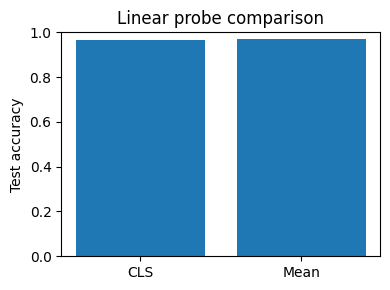

In [23]:
# --- run: CLS probe ---
print("\n=== Training CLS linear probe ===")
probe_cls = ProbeCLS(hidden_dim, num_classes)
probe_cls = train_probe(probe_cls)
cls_acc = eval_probe(probe_cls)
print(f"CLS probe test accuracy: {cls_acc:.4f}")

# --- run: Mean-of-patches probe ---
print("\n=== Training MEAN-of-patches linear probe ===")
probe_mean = ProbeMeanPatch(hidden_dim, num_classes)
probe_mean = train_probe(probe_mean,10,1e-3)
mean_acc = eval_probe(probe_mean)
print(f"Mean-of-patches probe test accuracy: {mean_acc:.4f}")

# --- compare ---
better = "CLS" if cls_acc >= mean_acc else "MEAN"
print(f"\nWinner: {better} pooling  ({max(cls_acc, mean_acc):.4f} vs {min(cls_acc, mean_acc):.4f})")

# (optional) bar plot
plt.figure(figsize=(4,3))
plt.bar(["CLS", "Mean"], [cls_acc, mean_acc])
plt.ylim(0,1)
plt.ylabel("Test accuracy")
plt.title("Linear probe comparison")
plt.tight_layout()
plt.show()